<a href="https://colab.research.google.com/github/emshao/ece661_final_project/blob/main/gtzan_model_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE 661 Final Project Code

Authors:

### Basic imports

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd


# Specific Libraries
import os
import librosa
import librosa.display
import IPython.display as ipd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm import tqdm, trange
from tqdm.auto import tqdm

from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense ,Dropout

# import cv2
from tensorflow.keras.applications.resnet import preprocess_input

from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os


Mounted at /content/drive


### Getting RAW data from .wav files

In [2]:
zip_path = '/content/drive/My Drive/kaggle-gtzan.zip'
extract_path = '/content/gtzan_dataset'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("Dataset already extracted.")

Extraction complete!


In [3]:
## This is defining path to .wav files, AND defining CSV to read them

path = '/content/gtzan_dataset/Data/genres_original'
df = pd.read_csv("/content/gtzan_dataset/Data/features_30_sec.csv")
print(df.head())

class_counts = df['label'].value_counts()
print(class_counts)

          filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.wav  661794          0.350088         0.088757  0.130228   
1  blues.00001.wav  661794          0.340914         0.094980  0.095948   
2  blues.00002.wav  661794          0.363637         0.085275  0.175570   
3  blues.00003.wav  661794          0.404785         0.093999  0.141093   
4  blues.00004.wav  661794          0.308526         0.087841  0.091529   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.002827             1784.165850          129774.064525   
1  0.002373             1530.176679          375850.073649   
2  0.002746             1552.811865          156467.643368   
3  0.006346             1070.106615          184355.942417   
4  0.002303             1835.004266          343399.939274   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              2002.449060            85882.761315  ...   52.420910   
1              2039.036516        

### Data cleaning and preprocessing

In [4]:
## Method to extract the spectrogram from the initial .wav data, given file path

def features_extract(file):

    sample, sample_rate = librosa.load(file, res_type='kaiser_fast', sr=None)

    if sample_rate != 22050:
        sample = librosa.resample(sample, orig_sr=sample_rate, target_sr=22050)
        sample_rate = 22050

    spectrogram = librosa.feature.melspectrogram(y=sample, sr=sample_rate)
    spectrogram_db_mel = librosa.amplitude_to_db(spectrogram, ref=np.max)

    return spectrogram_db_mel

In [5]:
extracted_features = []

for _, row in tqdm(df.iterrows()):
    if(row['filename'] == "jazz.00054.wav"):
      continue # skipping one corrupted file !

    class_label = row['filename'].split('.')[0]  # Extract genre
    file_name = os.path.join(path, class_label, row['filename'])

    spectrogram = features_extract(file_name)
    extracted_features.append([spectrogram, class_label])

extracted_df = pd.DataFrame(extracted_features, columns=['spectrogram', 'class'])



0it [00:00, ?it/s]

TypeError: 'Index' object is not callable

In [6]:
print(extracted_df.columns)
print(extracted_df['class'].value_counts())

Index(['spectrogram', 'class'], dtype='object')
class
blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: count, dtype: int64


In [8]:
## creating X
def resize_spectrograms(df, target_size=(299, 299)):
    resized_spectrograms = []
    for spectrogram in df['spectrogram']:
        resized = resize(spectrogram, target_size, mode='constant', anti_aliasing=True)
        resized_spectrograms.append(resized)
    return np.array(resized_spectrograms)


X = resize_spectrograms(extracted_df)
X = X[..., np.newaxis]
X = np.repeat(X, 3, axis=3)

In [10]:
## creating y
genres = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

label_encoder = LabelEncoder()
extracted_df["Genre_numeric"] = label_encoder.fit_transform(extracted_df['class'])
integer_labels = label_encoder.fit_transform(genres)

print(extracted_df.columns)
print(extracted_df["Genre_numeric"].value_counts())

y = extracted_df['Genre_numeric']
y = y.to_numpy()

Index(['spectrogram', 'class', 'Genre_numeric'], dtype='object')
Genre_numeric
0    100
1    100
2    100
3    100
4    100
6    100
7    100
8    100
9    100
5     99
Name: count, dtype: int64


In [11]:
print(X.shape)
print(y.shape)

(999, 299, 299, 3)
(999,)


### Splitting data into Train and Test samples with 80/20 split

In [12]:
## splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

y_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_one_hot_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

print(y_one_hot.shape)
print(y_one_hot_test.shape)

(799, 299, 299, 3)
(200, 299, 299, 3)
(799,)
(200,)
(799, 10)
(200, 10)


## Creating Model

In [13]:
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [14]:
# Load ResNet152 pre-trained model
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # Adjust input shape

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of ResNet152
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add more Dense layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding dropout regularization for better generalization
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)  # Adding dropout regularization
x = Dense(256, activation='relu')(x)

predictions = Dense(10, activation='softmax')(x)  # Assuming y is defined somewhere else

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 305, 305, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 150, 150, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 150, 150, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 150, 150, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 152, 152, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 75, 75, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 75, 75, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 75, 75, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 75, 75, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 75, 75, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 75, 75, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 75, 75, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 61,127,818 (233.18 MB)

 Trainable params: 2,756,874 (10.52 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

## Training Base Model

20 epochs training


model saved as: feb9_resnet152_base_model.h5

In [16]:
import tensorflow as tf
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
model.build(input_shape=(None, 299, 299, 3))  # Adjust input shape if needed
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_one_hot, epochs=20, batch_size=16, validation_split=0.2)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 756ms/step - accuracy: 0.2002 - loss: 2.1978 - val_accuracy: 0.4500 - val_loss: 1.6294
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.4967 - loss: 1.5766 - val_accuracy: 0.5562 - val_loss: 1.2908
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.5807 - loss: 1.3144 - val_accuracy: 0.6062 - val_loss: 1.1409
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 252ms/step - accuracy: 0.6044 - loss: 1.1881 - val_accuracy: 0.6562 - val_loss: 1.0478
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 255ms/step - accuracy: 0.6553 - loss: 1.0360 - val_accuracy: 0.6250 - val_loss: 1.0201
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.6567 - loss: 1.0189 - val_accuracy: 0.6687 - val_loss: 0.9203
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.6935 - loss: 0.9807 - val_accuracy: 0.6562 - val_loss: 0.9236
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - accuracy: 0.6838 - loss: 0.9068 - val_accu

In [18]:
model.save('feb9_resnet152_base_model.h5')

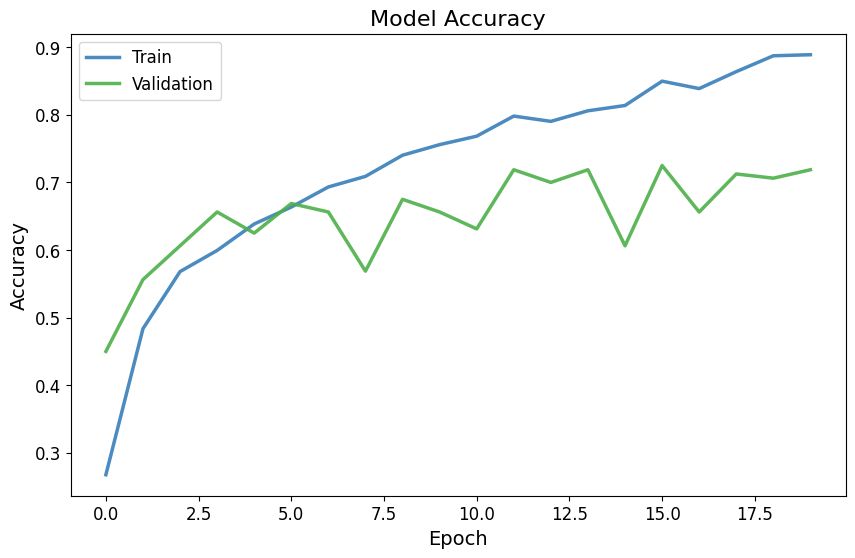

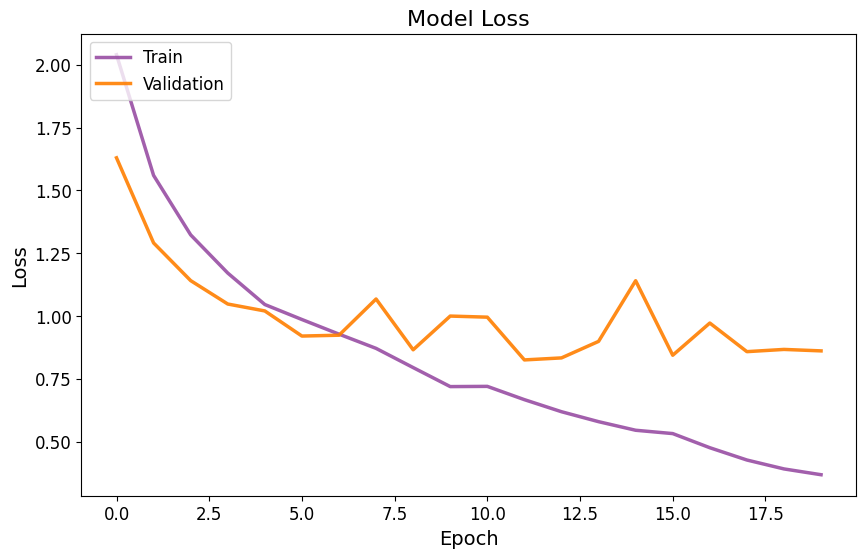

In [19]:

palette = plt.get_cmap('Set1')
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], marker='', color=palette(1), linewidth=2.5, alpha=0.9, label='Train')
plt.plot(history.history['val_accuracy'], marker='', color=palette(2), linewidth=2.5, alpha=0.9, label='Validation')
plt.title('Model Accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], marker='', color=palette(3), linewidth=2.5, alpha=0.9, label='Train')
plt.plot(history.history['val_loss'], marker='', color=palette(4), linewidth=2.5, alpha=0.9, label='Validation')
plt.title('Model Loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

## Testing Base Model

model tested: feb9_resnet152_base_model.h5

In [20]:
def evaluate_h5_model(h5_model_path, X_test, y_test):

    model = tf.keras.models.load_model(h5_model_path)
    input_shape = model.input_shape
    print(f"Model input shape: {input_shape}")

    X_test = X_test.astype(np.float32)
    predictions = model.predict(X_test)

    # Convert softmax output to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    actual_labels = np.argmax(y_test, axis=1)

    # Compute accuracy
    correct_predictions = np.sum(predicted_labels == actual_labels)
    total_samples = len(X_test)
    accuracy = correct_predictions / total_samples

    print(f"Accuracy for {h5_model_path}: {accuracy:.4f}")
    return accuracy

In [21]:
## should get around +0.74
evaluate_h5_model("feb9_resnet152_base_model.h5", X_test, y_one_hot_test)

Model input shape: (None, 299, 299, 3)
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Accuracy for feb9_resnet152_base_model.h5: 0.7800


0.78

# Optimization: ways to compress model size

In [22]:
# load model for all quantization + pruning to use
model = tf.keras.models.load_model("/content/feb9_resnet152_base_model.h5")

### Quantization

In [23]:
# Dynamic Range Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enables basic quantization
tflite_model = converter.convert()

with open("feb9_resnet152_dynamic_quant.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpep7tc8um'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138735823282896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823280208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823282320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823284240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823286160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13873582328712

In [24]:
# Float16 Quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]  # Convert weights to FP16
tflite_model = converter.convert()

with open("feb9_resnet152_fp16.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp4ezmbtph'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138735823282896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823280208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823282320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823284240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823286160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13873582328712

In [29]:
def representative_data_gen():
    for _ in range(100):  # Sample 100 batches from real data
        yield [tf.random.normal([1, 299, 299, 3])]  # Change to match model input size


In [30]:
# INT8 Quantization
# samples = np.random.choice(X_train.astype(np.int8).flatten(), size=100, replace=False)
#samples = (X_train.astype(np.int8))[:100]
y_one_hot_test_int8= y_one_hot_test.astype(np.int8)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

with open("feb9_resnet152_int8_quant.tflite", "wb") as f:
    f.write(tflite_model)



Saved artifact at '/tmp/tmplmvdbz1v'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  138735823282896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823281936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823280208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823282320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823284240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823285968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823288656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138735823286160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13873582328712

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [32]:
def check_tflite_output_shape(tflite_model_path):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    print(f"Checking: {tflite_model_path}")
    print(f"Output shape: {output_details[0]['shape']}")
    print(f"Expected number of classes: {output_details[0]['shape'][1]}")
    print("=" * 50)

check_tflite_output_shape("feb9_resnet152_dynamic_quant.tflite")
check_tflite_output_shape("feb9_resnet152_fp16.tflite")
check_tflite_output_shape("feb9_resnet152_int8_quant.tflite")

Checking: feb9_resnet152_dynamic_quant.tflite
Output shape: [ 1 10]
Expected number of classes: 10
Checking: feb9_resnet152_fp16.tflite
Output shape: [ 1 10]
Expected number of classes: 10
Checking: feb9_resnet152_int8_quant.tflite
Output shape: [ 1 10]
Expected number of classes: 10


### Pruning

In [33]:
### will fill in later??

### Evaluation of Quantized **Models**

In [45]:
def evaluate_tflite_model(tflite_model_path, X_test, y_test, is_int8=False):
    # Load TFLite model
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()

    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Get model input details
    input_shape = input_details[0]['shape']
    input_dtype = input_details[0]['dtype']  # Check expected dtype (float32 or int8)

    print(f"Model name: {tflite_model_path}")
    file_size = os.path.getsize(tflite_model_path)
    print(f"File size: {file_size}")
    print(f"Model input shape: {input_shape}, expected dtype: {input_dtype}")

    # Adjust data type for INT8 models
    if is_int8:
        # Get quantization parameters
        input_scale, input_zero_point = input_details[0]["quantization"]
        print(f"Quantization params -> Scale: {input_scale}, Zero Point: {input_zero_point}")

        # Convert float data to int8 (quantized)
        X_test_int8 = ((X_test / input_scale) + input_zero_point).astype(np.int8)
    else:
        X_test_int8 = X_test.astype(np.float32)  # Default to float32

    # Run inference
    correct_predictions = 0
    total_samples = len(X_test)

    for i in range(total_samples):
        input_data = np.expand_dims(X_test_int8[i], axis=0)  # Add batch dimension

        # Set input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get output tensor
        output_data = interpreter.get_tensor(output_details[0]['index'])

        # Debug: Print first few outputs
        if i < 3:
            print(f"Sample {i} -> Raw Output: {output_data}")

        # Convert softmax output to class label
        predicted_label = np.argmax(output_data)
        actual_label = np.argmax(y_test[i])

        if predicted_label == actual_label:
            correct_predictions += 1

    # Compute accuracy
    accuracy = correct_predictions / total_samples
    print(f"Accuracy for {tflite_model_path}: {accuracy:.4f}")
    return accuracy


### Verifying Accuracy

In [35]:
# Dynamic
evaluate_tflite_model("feb9_resnet152_dynamic_quant.tflite", X_test, y_one_hot_test)


Model name: feb9_resnet152_dynamic_quant.tflite
File size: 62085080
Model input shape: [  1 299 299   3], expected dtype: <class 'numpy.float32'>
Sample 0 -> Raw Output: [[4.45142905e-05 1.03142065e-05 7.78395224e-06 2.04773899e-03
  9.65372264e-01 2.07398734e-05 4.78404138e-04 2.21090429e-02
  7.70201487e-03 2.20712926e-03]]
Sample 1 -> Raw Output: [[8.8808978e-05 4.4884080e-05 7.2395345e-03 5.2963491e-03 1.3452535e-04
  2.3964727e-04 1.2242694e-04 9.6444547e-01 1.4120965e-03 2.0976231e-02]]
Sample 2 -> Raw Output: [[1.6276211e-02 1.2869673e-03 4.8096237e-01 1.3419759e-01 2.2676926e-05
  6.7171350e-04 4.5868214e-03 4.0685842e-03 3.9901608e-04 3.5752803e-01]]
Accuracy for feb9_resnet152_dynamic_quant.tflite: 0.7750


0.775

In [37]:
# FP16
evaluate_tflite_model("feb9_resnet152_fp16.tflite", X_test, y_one_hot_test)


Model name: feb9_resnet152_fp16.tflite
File size: 121780672
Model input shape: [  1 299 299   3], expected dtype: <class 'numpy.float32'>
Sample 0 -> Raw Output: [[6.0438011e-05 1.8072260e-05 1.7760203e-05 4.0131346e-03 9.4058257e-01
  2.4075220e-05 1.3740865e-03 3.4262691e-02 1.4948319e-02 4.6988665e-03]]
Sample 1 -> Raw Output: [[9.2967894e-05 5.9280603e-05 1.0331993e-02 7.1425126e-03 1.4171423e-04
  2.2255311e-04 2.3250766e-04 9.4207966e-01 1.4948912e-03 3.8201969e-02]]
Sample 2 -> Raw Output: [[7.8323986e-03 1.0620747e-03 3.7734020e-01 1.2192516e-01 1.2733596e-05
  3.7115131e-04 5.7266974e-03 4.1734581e-03 2.5394943e-04 4.8130217e-01]]
Accuracy for feb9_resnet152_fp16.tflite: 0.7800


0.78

In [46]:
# INT8
X_test_int8 = X_test.astype(np.int8)
y_one_hot_test_int8 = y_one_hot_test.astype(np.int8) # Ensure y_one_hot_test is also int8
evaluate_tflite_model("feb9_resnet152_int8_quant.tflite", X_test_int8, y_one_hot_test_int8, is_int8=True)

Model name: feb9_resnet152_int8_quant.tflite
File size: 63026488
Model input shape: [  1 299 299   3], expected dtype: <class 'numpy.int8'>
Quantization params -> Scale: 0.042633503675460815, Zero Point: 1
Sample 0 -> Raw Output: [[-128    9 -128 -128 -127 -128 -127 -128 -128  -11]]
Sample 1 -> Raw Output: [[-128  112 -128 -128 -128 -128 -128 -128 -128 -112]]
Sample 2 -> Raw Output: [[-128  127 -128 -128 -128 -128 -128 -128 -128 -127]]
Accuracy for feb9_resnet152_int8_quant.tflite: 0.0600


0.06